In [9]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from novelty.models.dists import benford_dist, instrumental_dist
from novelty.models.mlp import MLP
from novelty.models.util import train_streaming_unbalanced, test, train_streaming
from novelty.visualization.models import plot_accs

In [2]:
use_gpu = False
device = torch.device("mps" if use_gpu else "cpu")

In [3]:
epochs = 10
train_kwargs = {'batch_size': 1}
test_kwargs = {'batch_size': 1000}
if use_gpu:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # image mean and std 
    ])

In [4]:
dataset1 = datasets.MNIST('../data/raw', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data/raw', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [5]:
benford_probs = benford_dist(torch.arange(0,10))
max_scaler = max(benford_probs)

In [6]:
def prob_func_inverse(prob):
    return 0.001 * (1/prob) 

def prob_func_log(prob):
    return 0.01 * -torch.log(prob) / torch.log(torch.tensor(10))

# Naive Novelty Based Updates

Knowing that the samples are drawn from the Benford Distribution, we can attempt to scale our learning rate by the inverse of the probabilty 

In [7]:
examples_per_epoch = 10000
batches_per_epoch = examples_per_epoch//train_kwargs['batch_size']
epochs = len(train_loader.dataset)//examples_per_epoch

In [40]:
model = MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01)
kept_all = torch.zeros(10)
train_accs_normal = []
test_accs_normal = []

uniform_dist = lambda x: 0.1
# instrumental_dist = lambda x: 0.1
max_scaler = 0.1

for epoch in tqdm(range(1, epochs + 1)):
    # train_loss, train_acc, kept = train_streaming_unbalanced(model, device, train_loader, optimizer, epoch, 
    #                                                    benford_dist, instrumental_dist, max_scaler, 
    #                                                    batches_per_epoch, False)
    train_loss, train_acc, kept = train_streaming_unbalanced(model, device, train_loader, optimizer, epoch, 
                                                   benford_dist, instrumental_dist, max_scaler, 
                                                   batches_per_epoch, False)

    # train_loss, train_acc, kept = train_streaming(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)
    train_accs_normal.append(train_acc)
    test_accs_normal.append(test_acc)
    kept_all = kept_all + kept

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:04<00:00, 10.71s/it]


In [68]:
model = MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01)

train_accs_inverse = []
test_accs_inverse = []
for epoch in tqdm(range(1, epochs + 1)):
    train_loss, train_acc, kept = train_streaming_unbalanced(model, device, train_loader, optimizer, epoch, 
                                                       benford_dist, instrumental_dist, max_scaler, 
                                                       batches_per_epoch, True, prob_func_inverse)
    test_loss, test_acc = test(model, device, test_loader)
    train_accs_inverse.append(train_acc)
    test_accs_inverse.append(test_acc)

  0%|                                                                                                                                                                                                                                                                                                                                                             | 0/6 [00:00<?, ?it/s]


ValueError: only one element tensors can be converted to Python scalars

In [23]:
model = MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01)

train_accs_log = []
test_accs_log = []
for epoch in tqdm(range(1, epochs + 1)):
    train_loss, train_acc, kept = train_streaming_unbalanced(model, device, train_loader, optimizer, epoch, 
                                                       benford_dist, instrumental_dist, max_scaler, 
                                                       batches_per_epoch, True, prob_func_log)
    test_loss, test_acc = test(model, device, test_loader)
    train_accs_log.append(train_acc)
    test_accs_log.append(test_acc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:44<00:00,  7.39s/it]


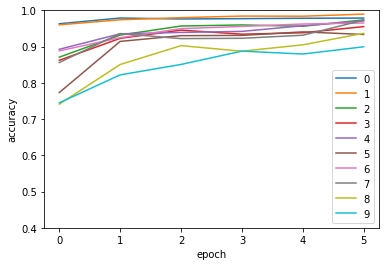

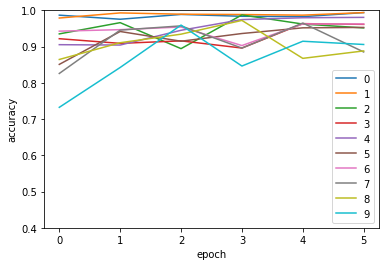

In [47]:
plot_accs(train_accs_normal)
plot_accs(test_accs_normal)

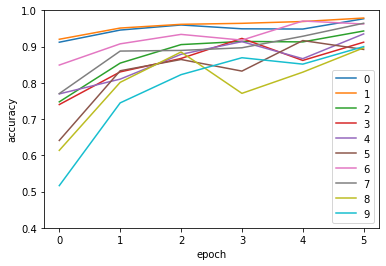

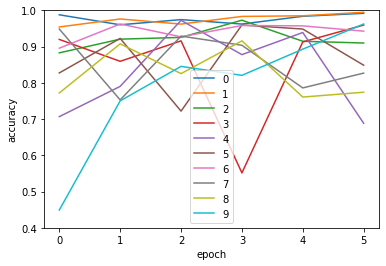

In [41]:
plot_accs(train_accs_inverse)
plot_accs(test_accs_inverse)

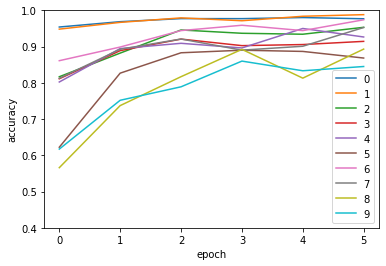

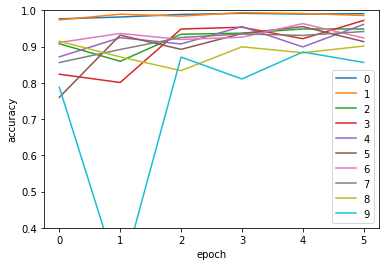

In [42]:
plot_accs(train_accs_log)
plot_accs(test_accs_log)

In [31]:
train_results = pd.DataFrame({
    'normal':train_accs_normal[-1],
    'inverse':train_accs_inverse[-1],
    'log':train_accs_log[-1]
})
results_melted = train_results.melt(var_name='method',value_name='accuracy')

<AxesSubplot:xlabel='method', ylabel='accuracy'>

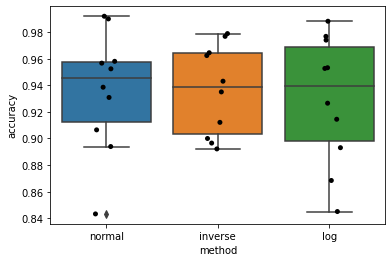

In [32]:
sns.boxplot(x = "method",
            y = "accuracy",
            data = results_melted)
sns.stripplot(x = "method",
              y = "accuracy",
              color = 'black',
              data = results_melted)

In [45]:
test_results = pd.DataFrame({
    'normal':test_accs_normal[-1],
    'inverse':test_accs_inverse[-1],
    'log':test_accs_log[-1]
})
results_melted = test_results.melt(var_name='method',value_name='accuracy')

<AxesSubplot:xlabel='method', ylabel='accuracy'>

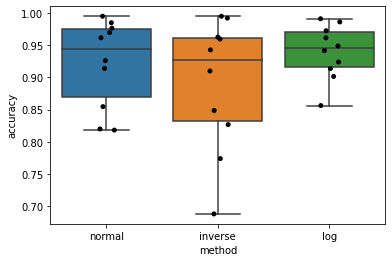

In [46]:
sns.boxplot(x = "method",
            y = "accuracy",
            data = results_melted)
sns.stripplot(x = "method",
              y = "accuracy",
              color = 'black',
              data = results_melted)

In [25]:
train_all = torch.stack([torch.stack(train_accs_normal),torch.stack(train_accs_inverse),torch.stack(train_accs_log)])
test_all = torch.stack([torch.stack(test_accs_normal),torch.stack(test_accs_inverse),torch.stack(test_accs_log)])

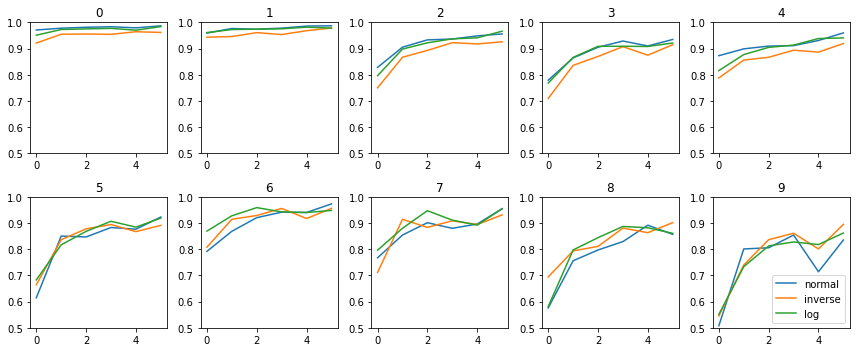

In [29]:
fig, axs = plt.subplots(2,5, figsize=(12, 5))
for i in range(10):
    ax = axs[int(i>4),i%5]
    ax.plot(train_all[:,:,i].T, label=['normal','inverse','log'])
    ax.set_title(str(i))
    ax.set_ylim([0.5, 1.0])
plt.legend()
fig.tight_layout()
plt.show()

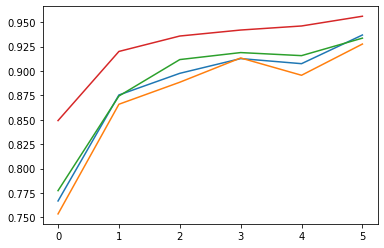

In [85]:
_ = plt.plot(train_all.mean(axis=-1).T)
plt.plot(torch.stack(train_accs_normal).mean(axis=-1))

In [75]:
torch.stack(train_accs_normal).mean(axis=-1)

tensor([0.3146, 0.5366, 0.7185, 0.7858, 0.8280, 0.8721,    nan,    nan,    nan,
           nan])

In [76]:
torch.stack(test_accs_normal).mean(axis=-1)

tensor([0.4391, 0.6605, 0.7714, 0.8343, 0.8632, 0.8732, 0.8732, 0.8732, 0.8732,
        0.8732])